In [73]:
from langgraph.graph import StateGraph , START, END
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from typing  import TypedDict , Annotated
import operator

In [74]:
load_dotenv()

True

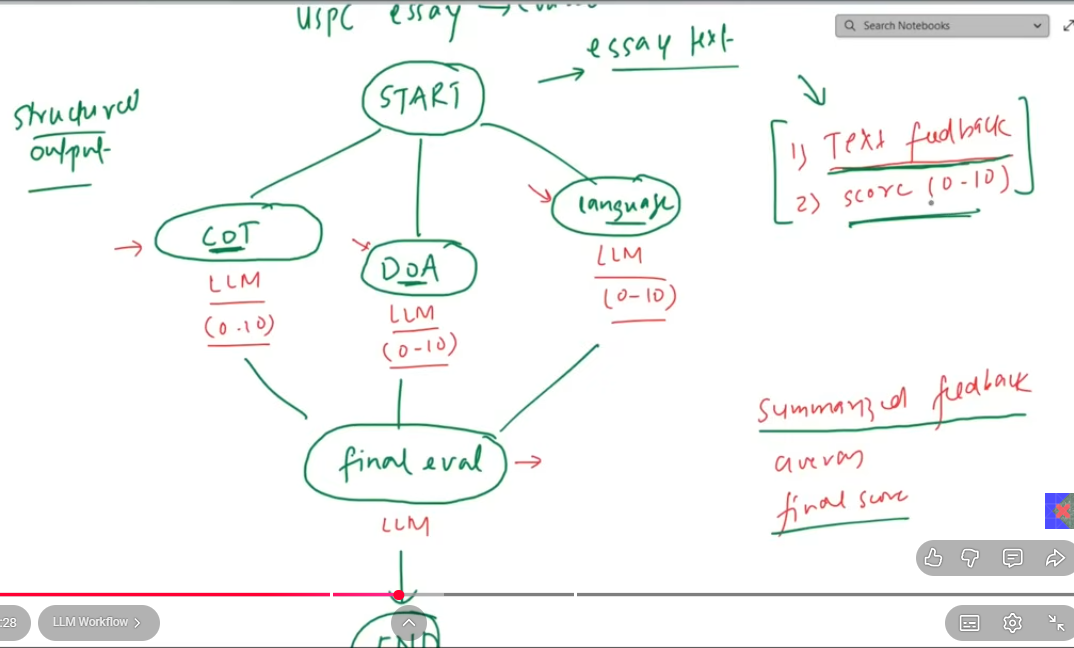

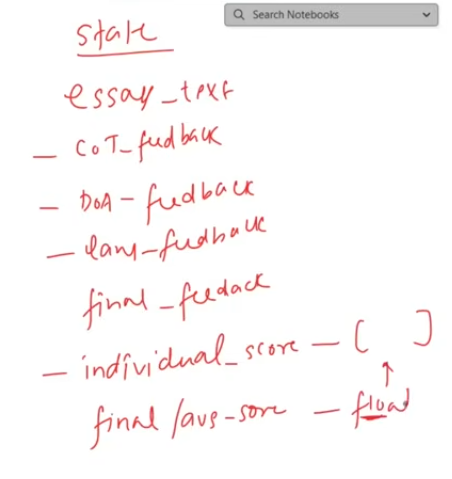

In [75]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [76]:
class EvaluationSchemea(BaseModel):
    feeback : str = Field(description="Detailed feedbacck for the essay")
    score: int = Field(description="Score out of 10", ge = 0 , le =10)

In [77]:
stru_model = model.with_structured_output(EvaluationSchemea)

In [78]:
essay = """Artificial Intelligence in Pakistan is rapidly evolving from a futuristic concept into a critical economic driver, fueled by a massive, tech-savvy youth population and a growing realization that the Fourth Industrial Revolution offers a unique chance for the country to leapfrog traditional development hurdles. The landscape is currently defined by a symbiotic relationship between government policy and private sector agility; initiatives like the draft National AI Policy and the National Center of Artificial Intelligence (NCAI) at NUST are attempting to create a structured framework for innovation and "smart" governance, while mass education programs like the Presidential Initiative for Artificial Intelligence & Computing (PIAIC) are democratizing access to high-tech skills for thousands. Simultaneously, the private sector is acting as the primary engine of growth, with major service exporters like Systems Limited and specialized product firms like Afiniti integrating AI into global enterprise solutions, alongside a booming freelance workforce that is increasingly pivoting toward machine learning and automation services. However, this promising trajectory faces significant friction from challenges such as a lack of digitized local data, inconsistent infrastructure, and the "brain drain" of top-tier engineers to foreign markets, meaning the country’s success will ultimately depend on its ability to improve digital infrastructure and retain talent to apply these technologies domestically in sectors like agri-tech and fintech, rather than just exporting them as services."""

In [79]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"
stru_model.invoke(prompt).score

8

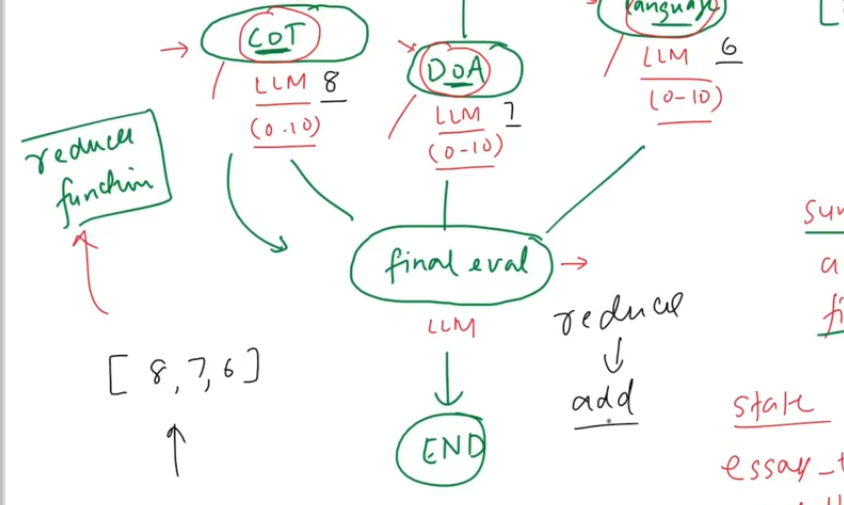 \
\
to prevent overwrite of opreator we need this reducer function named .add

In [80]:
class ESSAYState(TypedDict):
    essay: str
    language_feeback : str
    analysis_feeback : str
    clarity_feeback : str
    overall_feeback : str
    individual_scores: Annotated[list[int],operator.add]
    avg_score: float
    

In [81]:
def evaluate_language(state: ESSAYState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = stru_model.invoke(prompt)
    return {'language_feeback': output.feeback , 'individual_scores': [output.score]}

def evaluate_analysis(state: ESSAYState):
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = stru_model.invoke(prompt)
    return {'analysis_feeback': output.feeback , 'individual_scores': [output.score]}

def evaluate_thought(state: ESSAYState):
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = stru_model.invoke(prompt)
    return {'clarity_feeback': output.feeback , 'individual_scores': [output.score]}

def final_evaluation(state: ESSAYState) -> ESSAYState:
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback {state["language_feeback"]} \n depth of analysis feedback {state["analysis_feeback"]} \n clarity of thought feedback {state["clarity_feeback"]}'
    final_output = model.invoke(prompt).content
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feeback': final_output , 'avg_score': avg_score}


In [82]:
graph = StateGraph(ESSAYState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought',  evaluate_thought)
graph.add_node('final_evaluation',  final_evaluation)

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

In [83]:
intial_state = {
    'essay': essay,
}

workflow.invoke(intial_state)

{'essay': 'Artificial Intelligence in Pakistan is rapidly evolving from a futuristic concept into a critical economic driver, fueled by a massive, tech-savvy youth population and a growing realization that the Fourth Industrial Revolution offers a unique chance for the country to leapfrog traditional development hurdles. The landscape is currently defined by a symbiotic relationship between government policy and private sector agility; initiatives like the draft National AI Policy and the National Center of Artificial Intelligence (NCAI) at NUST are attempting to create a structured framework for innovation and "smart" governance, while mass education programs like the Presidential Initiative for Artificial Intelligence & Computing (PIAIC) are democratizing access to high-tech skills for thousands. Simultaneously, the private sector is acting as the primary engine of growth, with major service exporters like Systems Limited and specialized product firms like Afiniti integrating AI into